In [1]:
import deepchem as dc
from openpom.feat.graph_featurizer import GraphFeaturizer, GraphConvConstants
from openpom.utils.data_utils import get_class_imbalance_ratio
from openpom.models.mpnn_pom import MPNNPOMModel
from datetime import datetime


import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import deepchem as dc
import numpy as np
from deepchem.feat import GraphData
import pandas as pd
from deepchem.feat import DMPNNFeaturizer
import deepchem as dc


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [2]:
def get_graphs(weighted_adj_matrix):
    node_features = weighted_adj_matrix.diagonal().reshape(-1, 1)
    edges = np.array(np.nonzero(weighted_adj_matrix))
    edge_weights = weighted_adj_matrix[edges.T[:, 0], edges.T[:, 1]]
    graph = GraphData(node_features=node_features, edge_index=edges, edge_features=edge_weights.reshape(-1, 1))
    return graph

In [3]:
TASKS = [
'alcoholic', 'aldehydic', 'alliaceous', 'almond', 'amber', 'animal',
'anisic', 'apple', 'apricot', 'aromatic', 'balsamic', 'banana', 'beefy',
'bergamot', 'berry', 'bitter', 'black currant', 'brandy', 'burnt',
'buttery', 'cabbage', 'camphoreous', 'caramellic', 'cedar', 'celery',
'chamomile', 'cheesy', 'cherry', 'chocolate', 'cinnamon', 'citrus', 'clean',
'clove', 'cocoa', 'coconut', 'coffee', 'cognac', 'cooked', 'cooling',
'cortex', 'coumarinic', 'creamy', 'cucumber', 'dairy', 'dry', 'earthy',
'ethereal', 'fatty', 'fermented', 'fishy', 'floral', 'fresh', 'fruit skin',
'fruity', 'garlic', 'gassy', 'geranium', 'grape', 'grapefruit', 'grassy',
'green', 'hawthorn', 'hay', 'hazelnut', 'herbal', 'honey', 'hyacinth',
'jasmin', 'juicy', 'ketonic', 'lactonic', 'lavender', 'leafy', 'leathery',
'lemon', 'lily', 'malty', 'meaty', 'medicinal', 'melon', 'metallic',
'milky', 'mint', 'muguet', 'mushroom', 'musk', 'musty', 'natural', 'nutty',
'odorless', 'oily', 'onion', 'orange', 'orangeflower', 'orris', 'ozone',
'peach', 'pear', 'phenolic', 'pine', 'pineapple', 'plum', 'popcorn',
'potato', 'powdery', 'pungent', 'radish', 'raspberry', 'ripe', 'roasted',
'rose', 'rummy', 'sandalwood', 'savory', 'sharp', 'smoky', 'soapy',
'solvent', 'sour', 'spicy', 'strawberry', 'sulfurous', 'sweaty', 'sweet',
'tea', 'terpenic', 'tobacco', 'tomato', 'tropical', 'vanilla', 'vegetable',
'vetiver', 'violet', 'warm', 'waxy', 'weedy', 'winey', 'woody'
]
print("No of tasks: ", len(TASKS))

No of tasks:  138


In [4]:
import deepchem as dc
from openpom.feat.graph_featurizer import GraphFeaturizer, GraphConvConstants
from openpom.utils.data_utils import get_class_imbalance_ratio

In [5]:


from deepchem.feat import DMPNNFeaturizer
import deepchem as dc


featurizer = DMPNNFeaturizer()

smiles_field = 'nonStereoSMILES'


loader = dc.data.CSVLoader(
    tasks=TASKS,  
    feature_field=smiles_field,
    featurizer=featurizer
)
dataset = loader.create_dataset(inputs=["DMPNNpruned_without hydrogen_curated_GS_LF_merged_4812_QM_cleaned.csv"])
n_tasks = len(dataset.tasks)


In [6]:
data = np.load("DMPNNpruned_graph_data_cleaned.npz",allow_pickle=True)
mtx_list = data['mtx']
qm_graphs = []
for mtx in mtx_list:
    qm_graphs.append(get_graphs(mtx))
QM_X = np.asarray(qm_graphs)
QM_X
len(QM_X)


len(dataset)

4812

In [7]:
X = np.asarray([i for i in zip(dataset.X, QM_X)])
new_dataset = dc.data.NumpyDataset(X=X, y=dataset.y, n_tasks=138, ids=dataset.ids)

In [8]:


randomstratifiedsplitter = dc.splits.RandomStratifiedSplitter()
train_dataset, test_dataset, valid_dataset = randomstratifiedsplitter.train_valid_test_split(new_dataset, frac_train = 0.8, frac_valid = 0.1, frac_test = 0.1, seed = 1)

In [9]:
print("train_dataset: ", len(train_dataset))
print("valid_dataset: ", len(valid_dataset))
print("test_dataset: ", len(test_dataset))


train_dataset:  3839
valid_dataset:  485
test_dataset:  488


In [10]:
type(train_dataset)
import os
import deepchem as dc

def convert_to_disk_dataset(train_dataset, output_dir):
    """
    Converts a deepchem.data.datasets.NumpyDataset to a deepchem.data.datasets.DiskDataset.
    
    Parameters:
    train_dataset (deepchem.data.datasets.NumpyDataset): The input NumpyDataset to convert.
    output_dir (str): The directory to save the DiskDataset.
    
    Returns:
    deepchem.data.datasets.DiskDataset: The converted DiskDataset.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    X, y, w, ids = train_dataset.X, train_dataset.y, train_dataset.w, train_dataset.ids
    
    disk_dataset = dc.data.DiskDataset.from_numpy(X, y, w, ids, data_dir=output_dir)
    
    return disk_dataset
output_dir = './train_dataset'
train_dataset = convert_to_disk_dataset(train_dataset, output_dir)

In [11]:
train_ratios = get_class_imbalance_ratio(train_dataset)
assert len(train_ratios) == n_tasks

In [12]:


from deepchem.models.optimizers import ExponentialDecay

learning_rate = ExponentialDecay(initial_rate=0.005390333, decay_rate=0.777099289, decay_steps=764, staircase=True)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple, Union, Optional, Callable, Dict

from deepchem.models.losses import Loss, L2Loss
from deepchem.models.torch_models.torch_model import TorchModel
from deepchem.models.optimizers import Optimizer, LearningRateSchedule

from openpom.layers.pom_ffn import CustomPositionwiseFeedForward
from openpom.utils.loss import CustomMultiLabelLoss
from openpom.utils.optimizer import get_optimizer

try:
    import dgl
    from dgl import DGLGraph
    from dgl.nn.pytorch import Set2Set
    from openpom.layers.pom_mpnn_gnn import CustomMPNNGNN
except (ImportError, ModuleNotFoundError):
    raise ImportError('This module requires dgl and dgllife')


class MPNNPOM(nn.Module):

    def __init__(self,
                 n_tasks: int,
                 node_out_feats: int = 64,
                 edge_hidden_feats: int = 128,
                 edge_out_feats: int = 64,
                 num_step_message_passing: int = 3,
                 mpnn_residual: bool = True,
                 message_aggregator_type: str = 'sum',
                 mode: str = 'classification',
                 number_atom_features: int = 133,
                 number_bond_features: int = 14,
                 n_classes: int = 1,
                 nfeat_name: str = 'x',
                 efeat_name: str = 'edge_attr',
                 readout_type: str = 'set2set',
                 num_step_set2set: int = 6,
                 num_layer_set2set: int = 3,
                 ffn_hidden_list: List = [300],
                 ffn_embeddings: int = 256,
                 ffn_activation: str = 'relu',
                 ffn_dropout_p: float = 0.0,
                 ffn_dropout_at_input_no_act: bool = True):

        if mode not in ['classification', 'regression']:
            raise ValueError(
                "mode must be either 'classification' or 'regression'")

        super(MPNNPOM, self).__init__()

        self.n_tasks: int = n_tasks
        self.mode: str = mode
        self.n_classes: int = n_classes
        self.nfeat_name: str = nfeat_name
        self.efeat_name: str = efeat_name
        self.readout_type: str = readout_type
        self.ffn_embeddings: int = ffn_embeddings
        self.ffn_activation: str = ffn_activation
        self.ffn_dropout_p: float = ffn_dropout_p

        if mode == 'classification':
            self.ffn_output: int = n_tasks * n_classes
        else:
            self.ffn_output = n_tasks

        self.mpnn: nn.Module = CustomMPNNGNN(
            node_in_feats=number_atom_features,
            node_out_feats=node_out_feats,
            edge_in_feats=number_bond_features,
            edge_hidden_feats=edge_hidden_feats,
            num_step_message_passing=num_step_message_passing,
            residual=mpnn_residual,
            message_aggregator_type=message_aggregator_type)
        
        QM_node_out_features = 50
        
        self.QM_mpnn: nn.Module = CustomMPNNGNN(
            node_in_feats=1,
            node_out_feats=QM_node_out_features,
            edge_in_feats=1,
            edge_hidden_feats=16,
            num_step_message_passing=2,
            residual=True,
            message_aggregator_type='sum')

        self.project_edge_feats: nn.Module = nn.Sequential(
            nn.Linear(number_bond_features, edge_out_feats), nn.ReLU())

        if self.readout_type == 'set2set':
            self.readout_set2set: nn.Module = Set2Set(
                input_dim=node_out_feats + edge_out_feats,
                n_iters=num_step_set2set,
                n_layers=num_layer_set2set)
            ffn_input: int = 2 * (node_out_feats + edge_out_feats)
        elif self.readout_type == 'global_sum_pooling':
            ffn_input = node_out_feats + edge_out_feats
        else:
            raise Exception("readout_type invalid")

        if ffn_embeddings is not None:
            d_hidden_list: List = ffn_hidden_list + [ffn_embeddings]

        self.ffn: nn.Module = CustomPositionwiseFeedForward(
            d_input=ffn_input + QM_node_out_features,
            # d_input=ffn_input,
            d_hidden_list=d_hidden_list,
            d_output=self.ffn_output,
            activation=ffn_activation,
            dropout_p=ffn_dropout_p,
            dropout_at_input_no_act=ffn_dropout_at_input_no_act)

    def _readout(self, g: DGLGraph, node_encodings: torch.Tensor,
                 edge_feats: torch.Tensor) -> torch.Tensor:

        g.ndata['node_emb'] = node_encodings
        g.edata['edge_emb'] = self.project_edge_feats(edge_feats)

        def message_func(edges) -> Dict:
            """
            The message function to generate messages
            along the edges for DGLGraph.send_and_recv()
            """
            src_msg: torch.Tensor = torch.cat(
                (edges.src['node_emb'], edges.data['edge_emb']), dim=1)
            return {'src_msg': src_msg}

        def reduce_func(nodes) -> Dict:
            """
            The reduce function to aggregate the messages
            for DGLGraph.send_and_recv()
            """
            src_msg_sum: torch.Tensor = torch.sum(nodes.mailbox['src_msg'],
                                                  dim=1)
            return {'src_msg_sum': src_msg_sum}

        # radius 0 combination to fold atom and bond embeddings together
        g.send_and_recv(g.edges(),
                        message_func=message_func,
                        reduce_func=reduce_func)

        if self.readout_type == 'set2set':
            batch_mol_hidden_states: torch.Tensor = self.readout_set2set(
                g, g.ndata['src_msg_sum'])
        elif self.readout_type == 'global_sum_pooling':
            batch_mol_hidden_states = dgl.sum_nodes(g, 'src_msg_sum')

        # batch_size x (node_out_feats + edge_out_feats)
        return batch_mol_hidden_states

    def forward(
        self, graphs: tuple[DGLGraph]
    ) -> Union[tuple[torch.Tensor, torch.Tensor, torch.Tensor], torch.Tensor]:
        g, qm_g = graphs
        node_feats: torch.Tensor = g.ndata[self.nfeat_name]
        edge_feats: torch.Tensor = g.edata[self.efeat_name]

        qm_node_feats: torch.Tensor = qm_g.ndata[self.nfeat_name]
        qm_edge_feats: torch.Tensor = qm_g.edata[self.efeat_name]

        node_encodings: torch.Tensor = self.mpnn(g, node_feats, edge_feats)

        QM_encodings: torch.Tensor = self.QM_mpnn(qm_g, qm_node_feats, qm_edge_feats)
        qm_g.ndata['node_emb'] = QM_encodings
        molecular_QM_encodings = dgl.sum_nodes(qm_g, 'node_emb')
        molecular_encodings: torch.Tensor = self._readout(
            g, node_encodings, edge_feats)
        if self.readout_type == 'global_sum_pooling':
            molecular_encodings = F.softmax(molecular_encodings, dim=1)

        embeddings: torch.Tensor
        out: torch.Tensor
        embeddings, out = self.ffn(torch.concat((molecular_encodings, molecular_QM_encodings), dim=1))


        if self.mode == 'classification':
            if self.n_tasks == 1:
                logits: torch.Tensor = out.view(-1, self.n_classes)
            else:
                logits = out.view(-1, self.n_tasks, self.n_classes)
            proba: torch.Tensor = F.sigmoid(
                logits)  # (batch, n_tasks, classes)
            if self.n_classes == 1:
                proba = proba.squeeze(-1)  # (batch, n_tasks)
            return proba, logits, embeddings
        else:
            return out


class MPNNPOMModel(TorchModel):

    def __init__(self,
                 n_tasks: int,
                 class_imbalance_ratio: Optional[List] = None,
                 loss_aggr_type: str = 'sum',
                 learning_rate: Union[float, LearningRateSchedule] = 0.001,
                 batch_size: int = 25,
                 node_out_feats: int = 64,
                 edge_hidden_feats: int = 128,
                 edge_out_feats: int = 64,
                 num_step_message_passing: int = 3,
                 mpnn_residual: bool = True,
                 message_aggregator_type: str = 'sum',
                 mode: str = 'regression',
                 number_atom_features: int = 133,
                 number_bond_features: int = 14,
                 n_classes: int = 1,
                 readout_type: str = 'set2set',
                 num_step_set2set: int = 6,
                 num_layer_set2set: int = 3,
                 ffn_hidden_list: List = [300],
                 ffn_embeddings: int = 256,
                 ffn_activation: str = 'relu',
                 ffn_dropout_p: float = 0.0,
                 ffn_dropout_at_input_no_act: bool = True,
                 weight_decay: float = 1e-5,
                 self_loop: bool = False,
                 optimizer_name: str = 'adam',
                 device_name: Optional[str] = None,
                 **kwargs):
        model: nn.Module = MPNNPOM(
            n_tasks=n_tasks,
            node_out_feats=node_out_feats,
            edge_hidden_feats=edge_hidden_feats,
            edge_out_feats=edge_out_feats,
            num_step_message_passing=num_step_message_passing,
            mpnn_residual=mpnn_residual,
            message_aggregator_type=message_aggregator_type,
            mode=mode,
            number_atom_features=number_atom_features,
            number_bond_features=number_bond_features,
            n_classes=n_classes,
            readout_type=readout_type,
            num_step_set2set=num_step_set2set,
            num_layer_set2set=num_layer_set2set,
            ffn_hidden_list=ffn_hidden_list,
            ffn_embeddings=ffn_embeddings,
            ffn_activation=ffn_activation,
            ffn_dropout_p=ffn_dropout_p,
            ffn_dropout_at_input_no_act=ffn_dropout_at_input_no_act)

        if class_imbalance_ratio and (len(class_imbalance_ratio) != n_tasks):
            raise Exception("size of class_imbalance_ratio \
                            should be equal to n_tasks")

        if mode == 'regression':
            loss: Loss = L2Loss()
            output_types: List = ['prediction']
        else:
            loss = CustomMultiLabelLoss(
                class_imbalance_ratio=class_imbalance_ratio,
                loss_aggr_type=loss_aggr_type,
                device=device_name)
            output_types = ['prediction', 'loss', 'embedding']

        optimizer: Optimizer = get_optimizer(optimizer_name)
        optimizer.learning_rate = learning_rate
        if device_name is not None:
            device: Optional[torch.device] = torch.device(device_name)
        else:
            device = None
        super(MPNNPOMModel, self).__init__(model,
                                           loss=loss,
                                           output_types=output_types,
                                           optimizer=optimizer,
                                           learning_rate=learning_rate,
                                           batch_size=batch_size,
                                           device=device,
                                           **kwargs)

        self.weight_decay: float = weight_decay
        self._self_loop: bool = self_loop
        self.regularization_loss: Callable = self._regularization_loss

    def _regularization_loss(self) -> torch.Tensor:
        l1_regularization: torch.Tensor = torch.tensor(0., requires_grad=True)
        l2_regularization: torch.Tensor = torch.tensor(0., requires_grad=True)
        for name, param in self.model.named_parameters():
            if 'bias' not in name:
                l1_regularization = l1_regularization + torch.norm(param, p=1)
                l2_regularization = l2_regularization + torch.norm(param, p=2)
        l1_norm: torch.Tensor = self.weight_decay * l1_regularization
        l2_norm: torch.Tensor = self.weight_decay * l2_regularization
        return l1_norm + l2_norm

    def _prepare_batch(self, batch):
        inputs, labels, weights = batch
        
        # If inputs already contains DGLGraph objects
        if isinstance(inputs[0][0][0], dgl.DGLGraph):
            g1 = dgl.batch([graph for graph, _ in inputs[0]]).to(self.device)
            g2 = dgl.batch([graph for _, graph in inputs[0]]).to(self.device)
        else:
            # Original code for GraphData objects
            dgl_graphs1 = [
                graphs[0].to_dgl_graph(self_loop=self._self_loop)
                for graphs in inputs[0]
            ]
            g1 = dgl.batch(dgl_graphs1).to(self.device)
            
            dgl_graphs2 = [
                graphs[1].to_dgl_graph(self_loop=self._self_loop)
                for graphs in inputs[0]
            ]
            g2 = dgl.batch(dgl_graphs2).to(self.device)
            
        _, labels, weights = super(MPNNPOMModel, self)._prepare_batch(
            ([], labels, weights))
        return (g1, g2), labels, weights




In [14]:
model = MPNNPOMModel(n_tasks = n_tasks,
                            batch_size=25,
                            learning_rate=learning_rate,
                            class_imbalance_ratio = train_ratios,
                            loss_aggr_type = 'sum',
                            node_out_feats = 25,
                            edge_hidden_feats = 75,
                            edge_out_feats = 25,
                            num_step_message_passing = 5,
                            mpnn_residual = True,
                            message_aggregator_type = 'max',
                            mode = 'classification',
                            number_atom_features = 133,
                            number_bond_features = 14,
                            n_classes = 1,
                            readout_type = 'set2set',
                            num_step_set2set = 3,
                            num_layer_set2set = 2,
                            ffn_hidden_list= [512, 512],
                            ffn_embeddings = 256,
                            ffn_activation = 'relu',
                            ffn_dropout_p = 0.154493949,
                            ffn_dropout_at_input_no_act = False,
                            weight_decay = 1.39e-6,
                            self_loop = False,
                            optimizer_name = 'adam',
                            log_frequency = 32,
                            model_dir = './DMPNN+QM_epoch_40/experiments',
                            device_name='cpu')

model.restore(r"C:\Users\sarab\OneDrive\Desktop\CSIR\hyperparamter_dmpnn\DMPNN+QM_epoch_40\experiments\checkpoint2.pt")

c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

In [15]:
nb_epoch = 100


In [16]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

In [17]:
loss_e = model.evaluate(valid_dataset, [metric])

c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\feat\graph_data.py:193: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  g.ndata['x'] = torch.from_numpy(self.node_features).float()


In [18]:
loss_e

{'roc_auc_score': 0.863525506039406}

In [19]:
test_scores = model.evaluate(test_dataset, [metric])['roc_auc_score']

print("test_score: ", test_scores)

test_score:  0.8591745991307085


In [20]:
from rdkit import Chem

import pandas as pd

In [49]:
INDEX = 100
odor = "camphoreous"

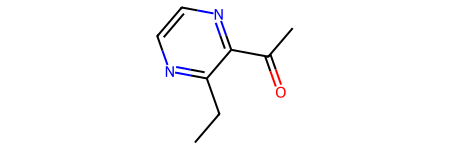

In [50]:
Test_SMILES = test_dataset.ids[INDEX]

mol = Chem.MolFromSmiles(Test_SMILES)
y = Chem.MolToSmiles(mol)
mol

In [51]:

plt.rcParams["figure.figsize"] = [10, 6]


%config InlineBackend.figure_format = 'retina'

In [52]:
len(test_dataset)

488

[0.0766834  0.03611184 0.04331208 0.26966736 0.06729811 0.18080069
 0.1020954  0.00594204 0.02845365 0.16429244 0.07470138 0.00272995
 0.15502325 0.01559659 0.02515095 0.19143401 0.05331366 0.01567911
 0.44286522 0.11346725 0.05073101 0.07795648 0.385556   0.08061885
 0.14309354 0.01127519 0.15067539 0.05079955 0.37975946 0.04137879
 0.07831397 0.06828511 0.06235734 0.39832014 0.11308022 0.364784
 0.00636962 0.17858319 0.10076392 0.0957188  0.16144918 0.14710526
 0.0107063  0.0897809  0.2048513  0.43978265 0.05545996 0.22145286
 0.0787877  0.13367856 0.11182151 0.11687677 0.0259915  0.200842
 0.02766136 0.0198233  0.04570553 0.02804497 0.028652   0.23368028
 0.34729782 0.05245125 0.1519651  0.46235022 0.3038761  0.16024677
 0.01539552 0.06294683 0.03101062 0.04178556 0.05694947 0.02156931
 0.13388336 0.12510563 0.03867766 0.02733509 0.0874542  0.336679
 0.14476424 0.01754877 0.10152842 0.10052305 0.24576122 0.01395384
 0.03598038 0.04072704 0.40479976 0.07501879 0.67292386 0.15150793
 

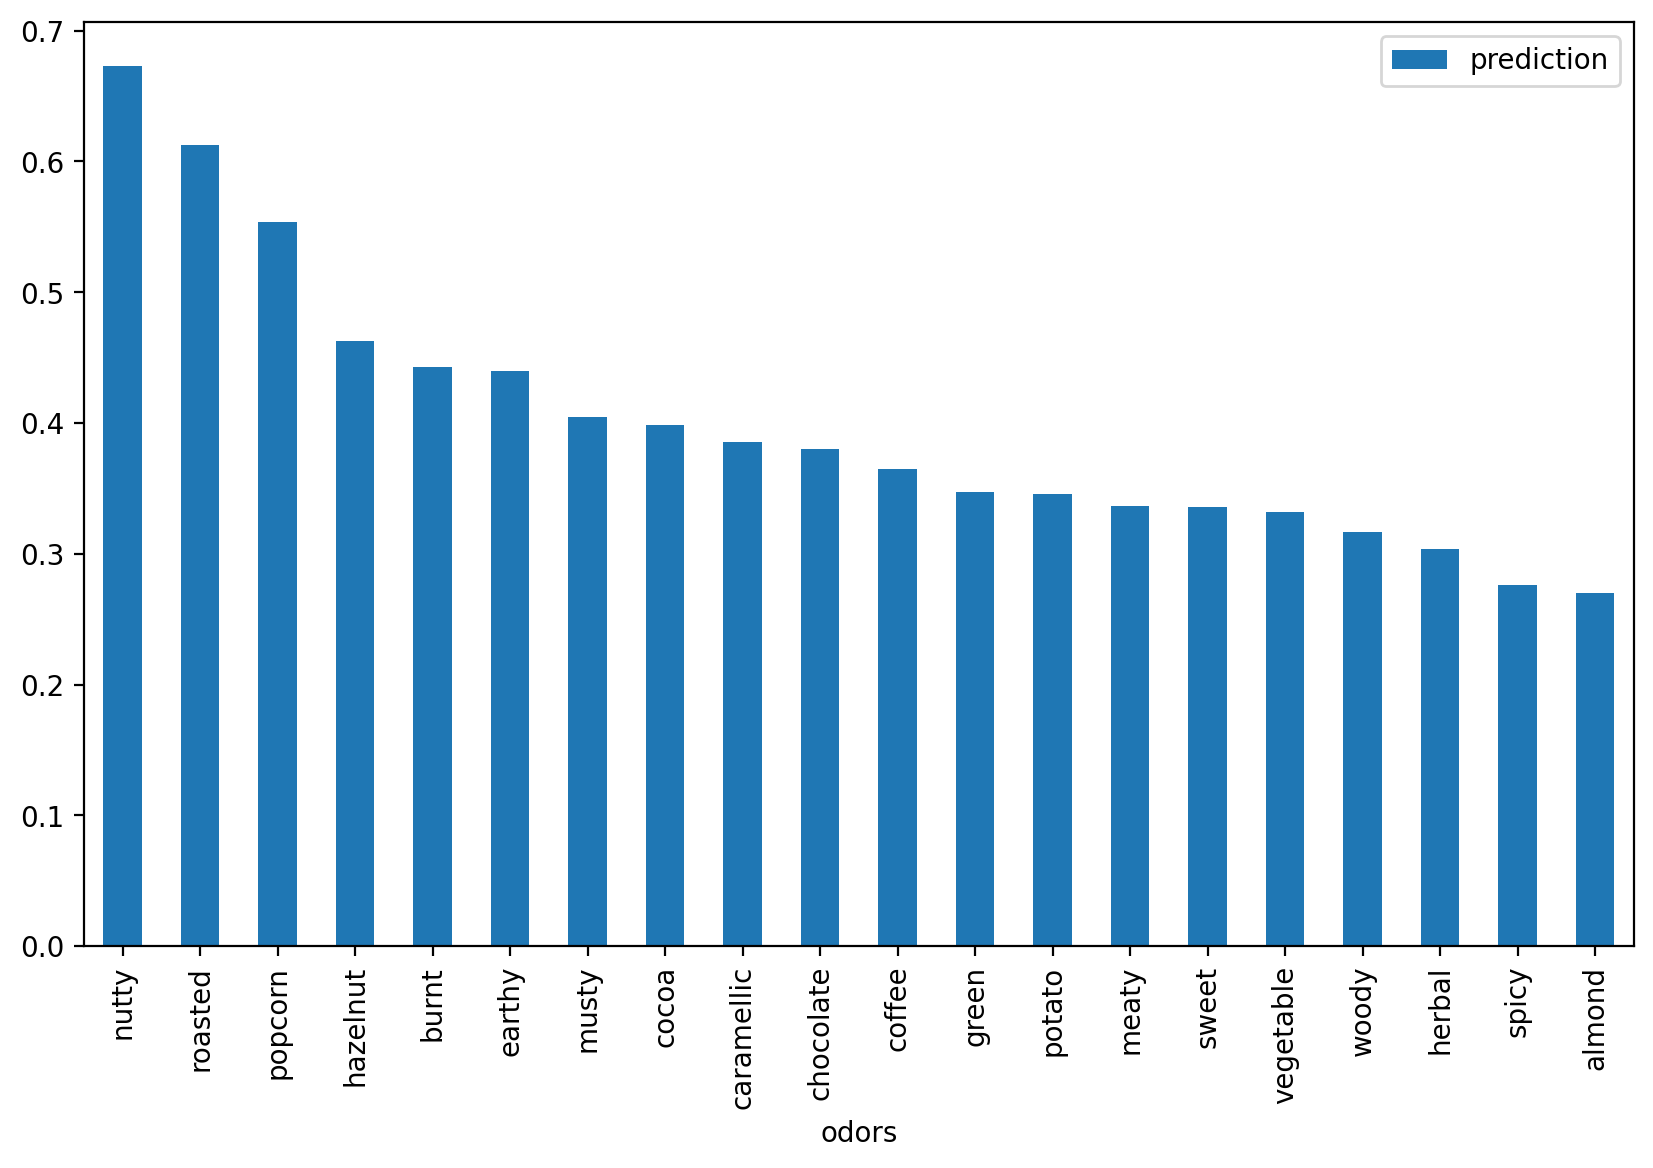

In [53]:
featurizer = DMPNNFeaturizer()
featurized_data = featurizer.featurize(Test_SMILES)

prediction = model.predict(test_dataset)
prediction = prediction[INDEX]
print(prediction)

prediction_flat = prediction.ravel()  

    
prediction_df = pd.DataFrame({
    'odors': TASKS * 1, 
    'prediction': prediction_flat
}).sort_values(by='prediction', ascending=False)



prediction_df[:20].plot.bar(x='odors', y='prediction')


prediction = prediction_flat

In [54]:
threshold = 0.5
inputs_labels = [(prediction > threshold).astype(int)]

In [55]:
featurized_data[0]

GraphData(node_features=[11, 133], edge_index=[2, 22], edge_features=[22, 14], global_features=[0])

In [56]:
inputs = [[featurized_data[0]]]

In [57]:
inputs_weights = np.array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [58]:
inputs=[]

first_test_sample = test_dataset.X[INDEX]  
mol_graph, qm_graph = first_test_sample


inputs = [mol_graph, qm_graph]


In [ ]:
import dgl
import torch

def deepchem_to_dgl(graph, self_loop=False):
    """Convert DeepChem's GraphData to DGLGraph"""
    src, dst = graph.edge_index  
    
    
    dgl_graph = dgl.graph((src.tolist(), dst.tolist()))
    

    if self_loop:
        dgl_graph = dgl.add_self_loop(dgl_graph)

    if hasattr(graph, 'node_features') and graph.node_features is not None:
        dgl_graph.ndata['x'] = torch.tensor(graph.node_features, dtype=torch.float32)


    if hasattr(graph, 'edge_features') and graph.edge_features is not None:
        dgl_graph.edata['edge_attr'] = torch.tensor(graph.edge_features, dtype=torch.float32)

    return dgl_graph

In [60]:


graph = inputs[0]
graph
dgl_graph = dgl.DGLGraph()
dgl_graph.add_nodes(graph.node_features.shape[0])
dgl_graph.add_edges(graph.edge_index[0], graph.edge_index[1])
dgl_graph.ndata['x'] = torch.tensor(graph.node_features, dtype=torch.float32)
    

dgl_graph.edata['edge_attr'] = torch.tensor(graph.edge_features, dtype=torch.float32)
graph = inputs[1]
dgl_qm_graph = dgl.DGLGraph()
dgl_qm_graph.add_nodes(graph.node_features.shape[0])
dgl_qm_graph.add_edges(graph.edge_index[0], graph.edge_index[1])
dgl_qm_graph.ndata['x'] = torch.ones(graph.node_features.shape[0], 1, dtype=torch.float32)
dgl_qm_graph.edata['edge_attr'] = torch.tensor(graph.edge_features, dtype=torch.float32)

modified_inputs = [[[dgl_graph, dgl_qm_graph]]]

c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [61]:


g, labels, weights = model._prepare_batch((modified_inputs, inputs_labels, inputs_weights))

In [62]:
g

(Graph(num_nodes=11, num_edges=22,
       ndata_schemes={'x': Scheme(shape=(133,), dtype=torch.float32)}
       edata_schemes={'edge_attr': Scheme(shape=(14,), dtype=torch.float32)}),
 Graph(num_nodes=11, num_edges=121,
       ndata_schemes={'x': Scheme(shape=(1,), dtype=torch.float32)}
       edata_schemes={'edge_attr': Scheme(shape=(1,), dtype=torch.float32)}))

In [63]:
type(inputs)

list

In [64]:
print(type(graph.edge_index))
print(graph.edge_index.shape)
print(type(graph.node_features))
print(graph.node_features.shape)
print(type(graph.edge_features))
print(graph.edge_features.shape)

<class 'numpy.ndarray'>
(2, 121)
<class 'numpy.ndarray'>
(11, 1)
<class 'numpy.ndarray'>
(121, 1)


In [ ]:
import numpy as np



highest_index = TASKS.index(odor)

"""
The integrated gradients method typically requires specifying a target class for which the gradients are computed. 
In this context, the target class is chosen as the odor label with the highest predicted probability or odor label of interest. 
This approach helps to focus the explanation on the most relevant prediction made by the model.
"""

target = int(highest_index)

print("Index of the highest value:", highest_index)
print("Label:", TASKS[highest_index])

Index of the highest value: 21
Label: camphoreous


In [66]:
import torch
from functools import partial
from captum.attr import IntegratedGradients
from torch_geometric.utils import from_dgl, to_dgl

In [67]:
data = from_dgl(g[0])

In [68]:
type(g[0])

dgl.heterograph.DGLGraph

In [69]:
torch.backends.cudnn.enabled=False

In [70]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:

def model_edge_forward_g1(edge_mask, g_tuple):
    g1, g2 = g_tuple  
    

    g1_copy = g1.clone()
    g2_copy = g2.clone()
    
    g1_copy.edata['edge_attr'] = edge_mask
    
    
    out = model.model((g1_copy, g2_copy))
    return out[0]  



g1, g2 = g


edge_attr_g1 = g1.edata['edge_attr'].requires_grad_(True).to(device)
ig_g1 = IntegratedGradients(partial(model_edge_forward_g1, g_tuple=g))
print(f"G1 edge features shape: {edge_attr_g1.shape}")
ig_attr_edge_g1 = ig_g1.attribute(edge_attr_g1, target=target,
                           internal_batch_size=g1.num_edges(), n_steps=3)

print(f"G1 attribution shape: {ig_attr_edge_g1.shape}")


G1 edge features shape: torch.Size([22, 14])
G1 attribution shape: torch.Size([22, 14])


In [ ]:

def model_node_forward_g1(node_mask, g_tuple):
    g1, g2 = g_tuple  
    
    
    g1_copy = g1.clone()
    g2_copy = g2.clone()
    
    
    data_g1 = from_dgl(g1_copy)
    data_g1.x = node_mask
    g1_modified = to_dgl(data_g1)
    
    
    out = model.model((g1_modified, g2_copy))
    return out[0]  



g1, g2 = g


data_g1 = from_dgl(g1)
node_mask_g1 = data_g1.x.requires_grad_(True).to(device)
ig_g1 = IntegratedGradients(partial(model_node_forward_g1, g_tuple=g))
print(f"G1 node features shape: {node_mask_g1.shape}")
ig_attr_node_g1 = ig_g1.attribute(node_mask_g1, target=target,
                           internal_batch_size=g1.num_nodes(), n_steps=3)


print(f"G1 node attribution shape: {ig_attr_node_g1.shape}")


G1 node features shape: torch.Size([11, 133])
G1 node attribution shape: torch.Size([11, 133])


In [73]:
from __future__ import print_function
from rdkit.Chem.Draw import rdMolDraw2D
import io
from PIL import Image
from collections import defaultdict
from rdkit.Chem import rdmolfiles
from rdkit.Chem import rdmolops
from collections import defaultdict
from rdkit.Chem.Draw import rdMolDraw2D

In [ ]:


order = rdmolfiles.CanonicalRankAtoms(mol)
mol = rdmolops.RenumberAtoms(mol, order)

In [75]:
colors = [(1.0, 0.1, 0.0), (0.3, 1.0, 0.0)]

athighlights = defaultdict(list)
arads = {}

bndhighlights = defaultdict(list)

Number of atoms in mol: 11
Length of node_list_g1: 11
Number of bonds in mol: 11
Length of edge_list_g1: 11
CCc1nccnc1C(C)=O INDEX: 100


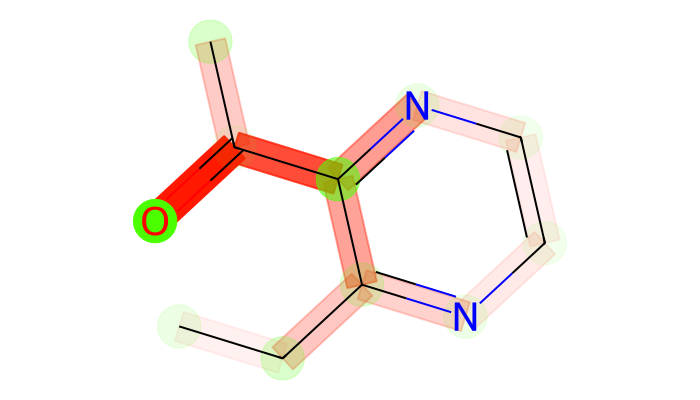

In [ ]:

if len(ig_attr_node_g1.shape) > 1:
    
    ig_attr_node_g1 = ig_attr_node_g1.abs().sum(dim=1)
else:
    
    ig_attr_node_g1 = ig_attr_node_g1.abs()


if ig_attr_node_g1.max() > 0:
    ig_attr_node_g1 /= ig_attr_node_g1.max()
node_list_g1 = ig_attr_node_g1.tolist()




if len(ig_attr_edge_g1.shape) > 1:
    sum_tensor_g1 = ig_attr_edge_g1.abs().sum(dim=1)
else:
    sum_tensor_g1 = ig_attr_edge_g1.abs()


if sum_tensor_g1.shape[0] % 2 == 0:
    
    ig_attr_edge_g1 = sum_tensor_g1.view(-1, 2)
    
    ig_attr_edge_g1 = torch.sum(ig_attr_edge_g1, dim=1)
else:
    print(f"Warning: G1 has {sum_tensor_g1.shape[0]} edges, which is not an even number. Using raw edge attributions.")
    ig_attr_edge_g1 = sum_tensor_g1


if ig_attr_edge_g1.max() > 0:
    ig_attr_edge_g1 /= ig_attr_edge_g1.max()
edge_list_g1 = ig_attr_edge_g1.tolist()



order = rdmolfiles.CanonicalRankAtoms(mol)
mol = rdmolops.RenumberAtoms(mol, order)


athighlights = defaultdict(list)
print(f"Number of atoms in mol: {mol.GetNumAtoms()}")
print(f"Length of node_list_g1: {len(node_list_g1)}")

for i, a in enumerate(mol.GetAtoms()):
    aid = a.GetIdx()
    
    
    if i < len(node_list_g1):
        if node_list_g1[i] == 0:
            continue
        else:
            
            trans_atom = node_list_g1[i]
            athighlights[aid].append((colors[1][0], colors[1][1], colors[1][2], trans_atom))
    else:
        
        print(f"Warning: Atom {i} doesn't have a corresponding attribution value")



bndhighlights = defaultdict(list)
print(f"Number of bonds in mol: {mol.GetNumBonds()}")
print(f"Length of edge_list_g1: {len(edge_list_g1)}")

for i, a in enumerate(mol.GetBonds()):
    aid1 = a.GetBeginAtomIdx()
    aid2 = a.GetEndAtomIdx()
    
    
    if i < len(edge_list_g1):
        bid = mol.GetBondBetweenAtoms(aid1, aid2).GetIdx()
        
        trans_bnd = edge_list_g1[i]
        bndhighlights[bid].append((colors[0][0], colors[0][1], colors[0][2], trans_bnd))
    else:
        
        print(f"Warning: Bond {i} doesn't have a corresponding attribution value")


d2d = rdMolDraw2D.MolDraw2DCairo(700, 400)
d2d.DrawMoleculeWithHighlights(mol, "", dict(athighlights), dict(bndhighlights), arads, {})
d2d.FinishDrawing()
bio = io.BytesIO(d2d.GetDrawingText())
mol_img = Image.open(bio)
print(test_dataset.ids[INDEX]  , f"INDEX: {INDEX}")
display(mol_img)

